In [1]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xvzf aclImdb_v1.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclI

In [3]:
!pip install transformers
!pip install sentencepiece
!pip install gpustat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.5 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.1-py3-none-any.whl size=26298 sha256=0671f

In [4]:
import glob
import numpy as np
import random
import string
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pylab as plt

#baseline libs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import transformers
import warnings
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

from IPython.display import clear_output
from tensorflow.keras.utils import Progbar


torch.manual_seed(42)
np.random.seed(42)


warnings.filterwarnings('ignore')

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

TOKENIZER = AutoTokenizer.from_pretrained('bert-base-uncased')
DEVICE = torch.device(dev)  
FROZEN_BERT = AutoModel.from_pretrained('bert-base-uncased').to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Считаем данные и подготовим для работы

In [5]:
def read_reviews(reviews_glob_path, reviews_type):
  review_text, review_tone = [], []
  for f in tqdm_notebook(glob.glob(reviews_glob_path)):
    review = open(f, 'r').read()
    review_text.append(review)
    review_tone.append(reviews_type)
  print(f'Total samples of {reviews_type} = {len(review_text)}')
  return review_text, review_tone

pos_train_review_text, pos_train_review_tone = read_reviews('/content/aclImdb/train/pos/*.txt', 'positive')
neg_train_review_text, neg_train_review_tone = read_reviews('/content/aclImdb/train/neg/*.txt', 'negative')

pos_test_review_text, pos_test_review_tone = read_reviews('/content/aclImdb/test/pos/*.txt', 'positive')
neg_test_review_text, neg_test_review_tone = read_reviews('/content/aclImdb/test/neg/*.txt', 'negative')

train_text, train_target = pos_train_review_text+neg_train_review_text, pos_train_review_tone+neg_train_review_tone
test_text, test_target = pos_test_review_text+neg_test_review_text, pos_test_review_tone+neg_test_review_tone

train_df = pd.DataFrame({"text": train_text, "target": train_target})
test_df = pd.DataFrame({"text": test_text, "target": test_target})
print(f'Train shape - {train_df.shape[0]}, test shape - {test_df.shape[0]}')
full_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True).sample(frac=1,random_state=42)
print("Full df shape: ", full_df.shape[0])
full_df.head()

  0%|          | 0/12500 [00:00<?, ?it/s]

Total samples of positive = 12500


  0%|          | 0/12500 [00:00<?, ?it/s]

Total samples of negative = 12500


  0%|          | 0/12500 [00:00<?, ?it/s]

Total samples of positive = 12500


  0%|          | 0/12500 [00:00<?, ?it/s]

Total samples of negative = 12500
Train shape - 25000, test shape - 25000
Full df shape:  50000


,text,target
33553,Korean cinema has the ability to turn genres o...,positive
9427,Which do you think the average person would kn...,positive
199,After seeing this film at the SF Independent F...,positive
12447,This 1939 film from director John Ford and wri...,positive
39489,Just saw this at the cinema. I haven't read th...,negative


In [6]:
#preprocess text
punctuation_set = set(string.punctuation + '«»—')

class_dict = {"positive":1, "negative":0}

def clean_punctuation(input_text):
    space = " "
    # replace punctuation with spaces
    cleaned_string = "".join([c if c not in punctuation_set else space for c in input_text])
    # remove duplicate whitespaces
    cleaned_string = space.join(cleaned_string.split())
    return cleaned_string


def clean_punctuation_lower(input_text):
    cleaned_string = clean_punctuation(input_text).lower()
    return cleaned_string

full_df['text'] = full_df['text'].apply(lambda x: clean_punctuation_lower(x))
full_df['target'] = full_df['target'].apply(lambda x: class_dict[x])
full_df.head()

,text,target
33553,korean cinema has the ability to turn genres o...,1
9427,which do you think the average person would kn...,1
199,after seeing this film at the sf independent f...,1
12447,this 1939 film from director john ford and wri...,1
39489,just saw this at the cinema i haven t read the...,0


In [7]:
### Train test split
train_data, finetune_data, test_data = full_df[:2000], full_df[2000:4000], full_df[4000:5000]
print('Finetune data: ', finetune_data.shape)
print('Train shape: ', train_data.shape)
print('Test data: ', test_data.shape)

Finetune data:  (2000, 2)
Train shape:  (2000, 2)
Test data:  (1000, 2)


In [8]:
#class balance
print('Train distib: ')
print(train_data['target'].value_counts())
print('Finetune distib: ')
print(finetune_data['target'].value_counts())
print('Test distib: ')
print(test_data['target'].value_counts())

Train distib: 
1    1018
0     982
Name: target, dtype: int64
Finetune distib: 
1    1008
0     992
Name: target, dtype: int64
Test distib: 
0    530
1    470
Name: target, dtype: int64


### Baseline


In [11]:
# Simple TF-IDF + SVM approach = knowledge of important words + good separability in sparse space
baseline_model = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), 
                               SGDClassifier()).fit(train_data['text'], train_data['target'])
baseline_predicted = baseline_model.predict(test_data['text'])
print(classification_report(test_data['target'], baseline_predicted))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       530
           1       0.85      0.88      0.86       470

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



### BERT preprocessing and data loader preparation

https://huggingface.co/transformers/model_doc/bert.html

In [12]:
#tokenizer example
string_example = 'i have a funny story about dinosours'
print(TOKENIZER.tokenize(string_example))
print(TOKENIZER.encode(string_example))

['i', 'have', 'a', 'funny', 'story', 'about', 'dino', '##so', '##urs']
[101, 1045, 2031, 1037, 6057, 2466, 2055, 22412, 6499, 9236, 102]


In [13]:
def tokenize_samples(text_samples):
  tokenized_list = list(map(lambda x: TOKENIZER.encode(x, add_special_tokens=True), text_samples))
  return tokenized_list

def pad_samples(tokenized_list):
  BERT_MAX_LEN = 512
  result_list = []

  for sample in tokenized_list:
    if len(sample) < BERT_MAX_LEN:
      padded_sample = sample + [0]*(BERT_MAX_LEN-len(sample))
    else:
      padded_sample = sample[:BERT_MAX_LEN]
    result_list.append(padded_sample)

  padded_list = np.array(result_list)
  return padded_list

def mask_padded_list(padded_list):
  attention_mask = np.where(padded_list != 0, 1, 0)
  return attention_mask

def prepare_data(text_samples):
  tokenized_list = tokenize_samples(text_samples)
  padded_samples = pad_samples(tokenized_list)
  attention_mask = mask_padded_list(padded_samples)
  return padded_samples, attention_mask

train_input_ids, train_attention_mask = prepare_data(train_data['text'].tolist())
print('Train: ', train_input_ids.shape, train_attention_mask.shape)

finetune_input_ids, finetune_attention_mask = prepare_data(finetune_data['text'].tolist())
print('Val: ', finetune_input_ids.shape, finetune_attention_mask.shape)

test_input_ids, test_attention_mask = prepare_data(test_data['text'].values)
print('Test: ', test_input_ids.shape, test_attention_mask.shape)

Token indices sequence length is longer than the specified maximum sequence length for this model (1080 > 512). Running this sequence through the model will result in indexing errors


Train:  (2000, 512) (2000, 512)
Val:  (2000, 512) (2000, 512)
Test:  (1000, 512) (1000, 512)


In [14]:
class Dataset(TorchDataset):
    def __init__(self, samples, attention_map, targets):
        self.samples = samples
        self.attention_map = attention_map
        self.targets = targets
        self.classes_number = len(np.unique(targets))
        
    def __getitem__(self, index):
        return torch.tensor(self.samples[index], dtype=torch.int64).to(DEVICE), \
               torch.tensor(self.attention_map[index], dtype=torch.int64).to(DEVICE), \
               torch.tensor(self.targets[index], dtype=torch.float32).to(DEVICE)

    def __len__(self):
        return len(self.samples)


train_dataset = Dataset(train_input_ids, train_attention_mask, train_data['target'].tolist())
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)

finetune_dataset = Dataset(finetune_input_ids, finetune_attention_mask, finetune_data['target'].tolist())
finetune_loader = DataLoader(finetune_dataset, batch_size=8, shuffle=False)

test_dataset = Dataset(test_input_ids, test_attention_mask, test_data['target'].tolist())
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

def test():
    ids_vector, attention_vector, target = list(train_loader)[0]
    print(ids_vector.shape, attention_vector.shape, target.shape)
    print(ids_vector.dtype, attention_vector.dtype, target.dtype)


test()

torch.Size([8, 512]) torch.Size([8, 512]) torch.Size([8])
torch.int64 torch.int64 torch.float32


In [15]:
def encode_data(bert_model, data_loader):
    encoded_data, target_data = [], []
    bert_model.eval()
    with torch.no_grad():
        bar = Progbar(len(data_loader))
        for batch in data_loader:
          input_ids, attention_map, target = batch
          outputs = bert_model.forward(input_ids, attention_map)
          pooler_output = outputs['pooler_output']
          encoded_data.append(pooler_output)
          target_data.append(target)
          bar.add(1)
    encoded_data = torch.cat(encoded_data, dim=0)
    target_data =  torch.cat(target_data, dim=0)
    return encoded_data, target_data


train_bert_embeddings, train_target_data = encode_data(FROZEN_BERT, train_loader)
print('Train loader ready!')

finetune_bert_embeddings, finetune_target_data  = encode_data(FROZEN_BERT, finetune_loader)
print('Finetune loader ready!')

test_bert_embeddings, test_target_data = encode_data(FROZEN_BERT, test_loader)
print('Test loader ready!')

250/250 [==============================] - 59s 225ms/step
Train loader ready!
250/250 [==============================] - 59s 234ms/step
Finetune loader ready!
125/125 [==============================] - 30s 242ms/step
Test loader ready!


In [16]:
class BERTEmbeddingsDataset(TorchDataset):
    def __init__(self, samples, targets):
        self.samples = samples
        self.targets = targets
        
    def __getitem__(self, index):
        return self.samples[index].to(DEVICE), self.targets[index].to(DEVICE)

    def __len__(self):
        return len(self.samples)


train_dataset = BERTEmbeddingsDataset(train_bert_embeddings, train_target_data)
train_loader_emb = DataLoader(train_dataset, batch_size=8, shuffle=True)

finetune_dataset = BERTEmbeddingsDataset(finetune_bert_embeddings, finetune_target_data)
finetune_loader_emb = DataLoader(finetune_dataset, batch_size=8, shuffle=True)

test_dataset = BERTEmbeddingsDataset(test_bert_embeddings, test_target_data)
test_loader_emb = DataLoader(test_dataset, batch_size=8, shuffle=True)


def test():
    embedding,target  = list(train_loader_emb)[0]
    print(embedding.shape, target.shape)
    print(embedding.dtype, target.dtype)


test()

torch.Size([8, 768]) torch.Size([8])
torch.float32 torch.float32


### BERT Archtitecture

![bert_architecture](https://habrastorage.org/webt/ob/pa/a6/obpaa6snqryacqb9vbyaahue7zc.png)

In [ ]:
FROZEN_BERT.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
FROZEN_BERT.encoder

BertEncoder(
  (layer): ModuleList(
    (0): BertLayer(
      (attention): BertAttention(
        (self): BertSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): BertIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): BertOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       

In [ ]:
FROZEN_BERT

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
!gpustat

7a365089fcbd         Sun Apr 24 06:49:16 2022  460.32.03
[0] Tesla K80        | 73'C, 100 % |  1613 / 11441 MB |


### Use BERT embeddings as base vectorizer

In [17]:
class DenseModel(nn.Module):
  def __init__(self):
    super(DenseModel, self).__init__()
    self.fc1 = nn.Linear(768,512)
    self.dropout = nn.Dropout(0.1)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(512, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input):
    fc1_output = self.fc1(input)
    dropout_output = self.dropout(fc1_output)
    relu_output = self.relu(dropout_output)
    fc2_output = self.fc2(relu_output)
    proba = self.sigmoid(fc2_output)
    return proba

def test():
  embedding, target = list(train_loader_emb)[0]
  dense_model = DenseModel().to(DEVICE)
  prediction = dense_model.forward(embedding)
  for param in dense_model.named_parameters():
    print(param[0], param[1].requires_grad)
  print(prediction)
  print(target)

test()

fc1.weight True
fc1.bias True
fc2.weight True
fc2.bias True
tensor([[0.4475],
        [0.4435],
        [0.4480],
        [0.4566],
        [0.4677],
        [0.4640],
        [0.4506],
        [0.4629]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([1., 1., 1., 1., 0., 0., 0., 0.], device='cuda:0')


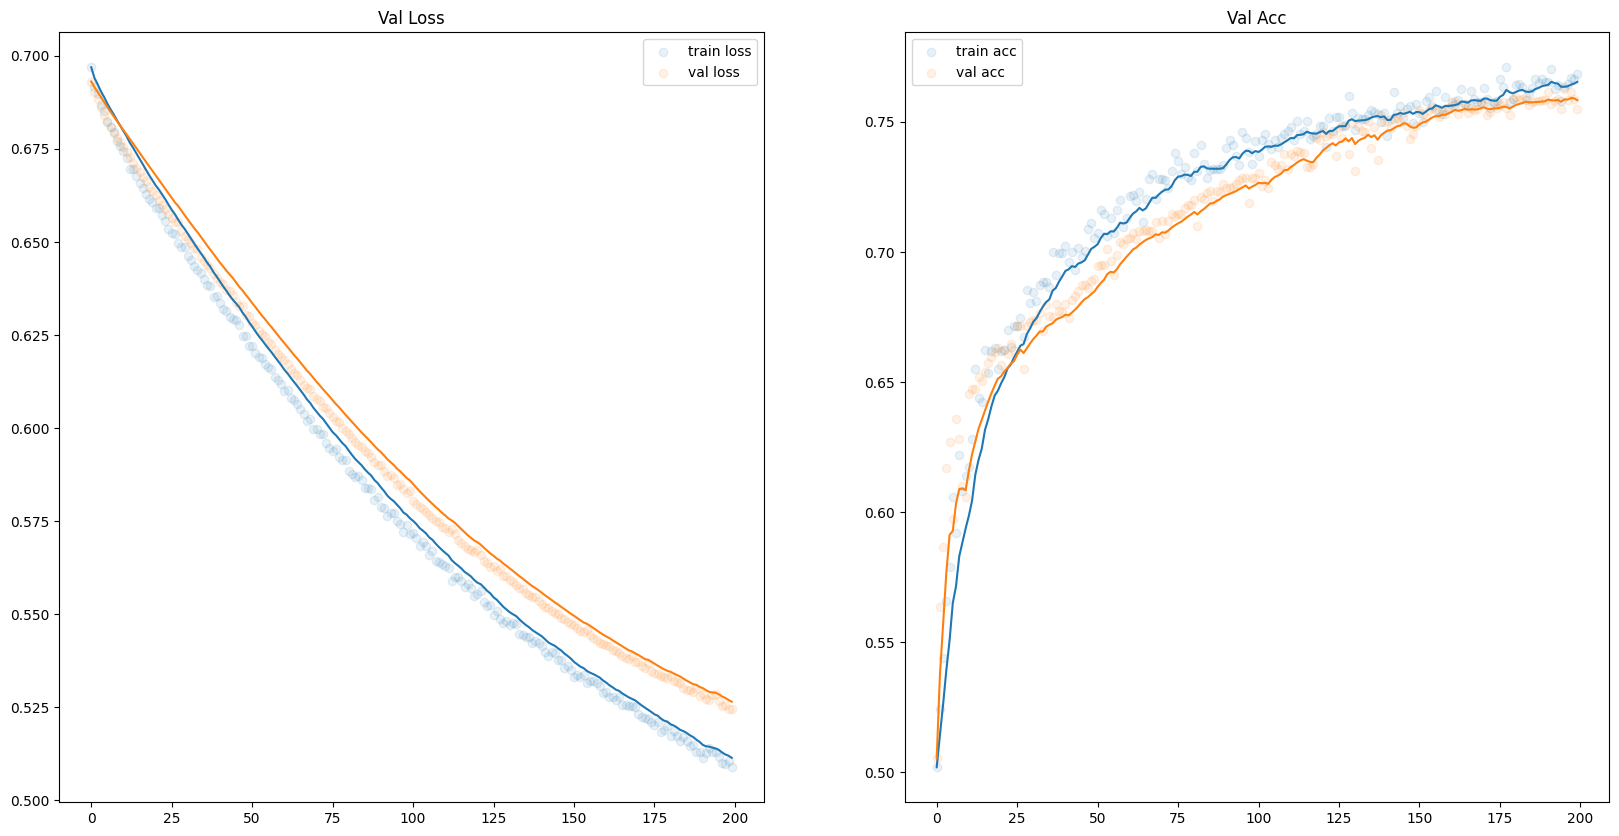

In [44]:
N_EPOCHS = 200
LEARNING_RATE=3e-6

dense_model = DenseModel().to(DEVICE)

optimizer = optim.Adam(dense_model.parameters(), lr=LEARNING_RATE)
loss_func = nn.BCELoss()

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

train_epoch_loss_array, val_epoch_loss_array = [], []
train_acc_epoch_array, val_acc_epoch_array = [], []

for epoch in range(N_EPOCHS):
  train_loss, val_loss,  = 0, 0
  train_acc, val_acc = 0, 0
  #train
  dense_model.train()
  for batch in finetune_loader_emb:
    embedding, target = batch

    dense_model.zero_grad()
    pred_proba = dense_model.forward(embedding).flatten()

    train_batch_loss = loss_func(pred_proba, target)
    train_loss += train_batch_loss.item()
    
    train_batch_loss.backward()
    optimizer.step()

    #evaluate train acc
    pred_proba_np = pred_proba.cpu().detach().numpy() 
    predicted_targets = pred_proba_np > 0.5
    true_values = target.cpu().detach().numpy() 
    true_values = true_values == 1
    train_acc += (predicted_targets == true_values).astype(float).sum()

  train_epoch_loss_array.append(train_loss / len(finetune_loader))
  train_acc_epoch_array.append(train_acc / len(finetune_dataset))

  #evaluate
  dense_model.eval()
  for batch in train_loader_emb:
    with torch.no_grad():
      embedding, target = batch

      pred_proba = dense_model.forward(embedding).flatten()
      
      val_batch_loss = loss_func(pred_proba, target)
      val_loss += val_batch_loss.item()

      #evaluate val acc
      pred_proba_np = pred_proba.cpu().detach().numpy() 
      predicted_targets = pred_proba_np > 0.5
      true_values = target.cpu().detach().numpy() 
      true_values = true_values == 1
      val_acc += (predicted_targets == true_values).astype(float).sum()      

  val_epoch_loss_array.append(val_loss / len(train_loader_emb))
  val_acc_epoch_array.append(val_acc / len(train_dataset))


  clear_output(True)
  plt.figure(figsize=[20, 10])
  #plot train loss
  plt.subplot(1, 2, 1), plt.title('Train Loss'), plt.grid()
  plt.scatter(np.arange(len(train_epoch_loss_array)), train_epoch_loss_array, alpha=0.1, label='train loss')
  plt.plot(ewma(train_epoch_loss_array, span=10))
  plt.legend()
  #plot train acc
  plt.subplot(1, 2, 2), plt.title('Train Acc'), plt.grid()
  plt.scatter(np.arange(len(train_acc_epoch_array)), train_acc_epoch_array, alpha=0.1, label='train acc')
  plt.plot(ewma(train_acc_epoch_array, span=10))
  plt.legend()
  #plot val loss
  plt.subplot(1, 2, 1), plt.title('Val Loss'), plt.grid()
  plt.scatter(np.arange(len(val_epoch_loss_array)), val_epoch_loss_array, alpha=0.1, label='val loss')
  plt.plot(ewma(val_epoch_loss_array, span=10))
  plt.legend()
  #plot val acc
  plt.subplot(1, 2, 2), plt.title('Val Acc'), plt.grid()
  plt.scatter(np.arange(len(val_acc_epoch_array)), val_acc_epoch_array, alpha=0.1, label='val acc')
  plt.plot(ewma(val_acc_epoch_array, span=10))
  plt.legend()
  plt.show()

In [45]:
dense_model.eval()
bert_predicted, true_y = [], []
bar=Progbar(len(test_loader_emb))
with torch.no_grad():
    for batch in test_loader_emb:
        embedding, target = batch
        logits = dense_model(embedding)
        pred_proba = logits.cpu().detach().numpy()
        bert_predicted += list(pred_proba[:, 0] > 0.5)
        true_y += list(target.cpu().detach().numpy())

        bar.add(1)

125/125 [==============================] - 0s 2ms/step


In [46]:
print(classification_report(true_y, bert_predicted))

              precision    recall  f1-score   support

         0.0       0.78      0.73      0.75       530
         1.0       0.72      0.76      0.74       470

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000



### Bert finetuning


In [39]:
import sys
from copy import deepcopy

import torch.nn as nn


class BERTClassifier(nn.Module):
    def __init__(self, bert_model, n_last_layers2train, debug_info=False):
        super(BERTClassifier, self).__init__()
        self.bert_module = deepcopy(bert_model)
        self.disable_bert_training()

        if 1 <= n_last_layers2train < len(self.bert_module.encoder.layer):
            self.modules2train = [*self.bert_module.encoder.layer[-n_last_layers2train:], self.bert_module.pooler]
        elif n_last_layers2train == len(self.bert_module.encoder.layer):
            self.modules2train = [*self.bert_module.encoder.layer[-n_last_layers2train:],
                                  self.bert_module.pooler, self.bert_module.embeddings]
        elif n_last_layers2train == 0:
            self.modules2train = [self.bert_module.pooler]
        elif n_last_layers2train == -1:
            self.modules2train = []
        else:
            print('Wrong params amount!')
            sys.exit()
        
        if debug_info:
            print('################')
            print('Encoder stack len: ', len(self.bert_module.encoder.layer))
            for name, param in self.bert_module.named_parameters():
                print(name, param.requires_grad)
            print('################')
        
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(self.bert_module.pooler.dense.weight.shape[0], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert_module(input_ids=input_ids, attention_mask = attention_mask)
        bert_pooler_output = bert_output.pooler_output
        dropout_output = self.dropout(bert_pooler_output)
        fc1_ouput = self.fc1(dropout_output)
        proba = self.sigmoid(fc1_ouput)
        return proba

    def disable_bert_training(self):
        for module in self.bert_module.parameters():
            module.requires_grad = False

    def enable_bert_layers_training(self):
        for module in self.modules2train:
            for param in module.parameters():
                param.requires_grad = True
    
def test():
  ids_vector, attention_vector, target = list(train_loader)[0]
  bert_finetune_model = BERTClassifier(FROZEN_BERT, 2, True).to(DEVICE)
  bert_finetune_model.enable_bert_layers_training()

  print('Trainable layers: ')
  for i in list(bert_finetune_model.named_parameters()):
      if i[1].requires_grad:
          print(i[0])
  prediction = bert_finetune_model.forward(ids_vector, attention_vector)
  print(prediction)

test()

################
Encoder stack len:  12
embeddings.word_embeddings.weight False
embeddings.position_embeddings.weight False
embeddings.token_type_embeddings.weight False
embeddings.LayerNorm.weight False
embeddings.LayerNorm.bias False
encoder.layer.0.attention.self.query.weight False
encoder.layer.0.attention.self.query.bias False
encoder.layer.0.attention.self.key.weight False
encoder.layer.0.attention.self.key.bias False
encoder.layer.0.attention.self.value.weight False
encoder.layer.0.attention.self.value.bias False
encoder.layer.0.attention.output.dense.weight False
encoder.layer.0.attention.output.dense.bias False
encoder.layer.0.attention.output.LayerNorm.weight False
encoder.layer.0.attention.output.LayerNorm.bias False
encoder.layer.0.intermediate.dense.weight False
encoder.layer.0.intermediate.dense.bias False
encoder.layer.0.output.dense.weight False
encoder.layer.0.output.dense.bias False
encoder.layer.0.output.LayerNorm.weight False
encoder.layer.0.output.LayerNorm.bias Fa

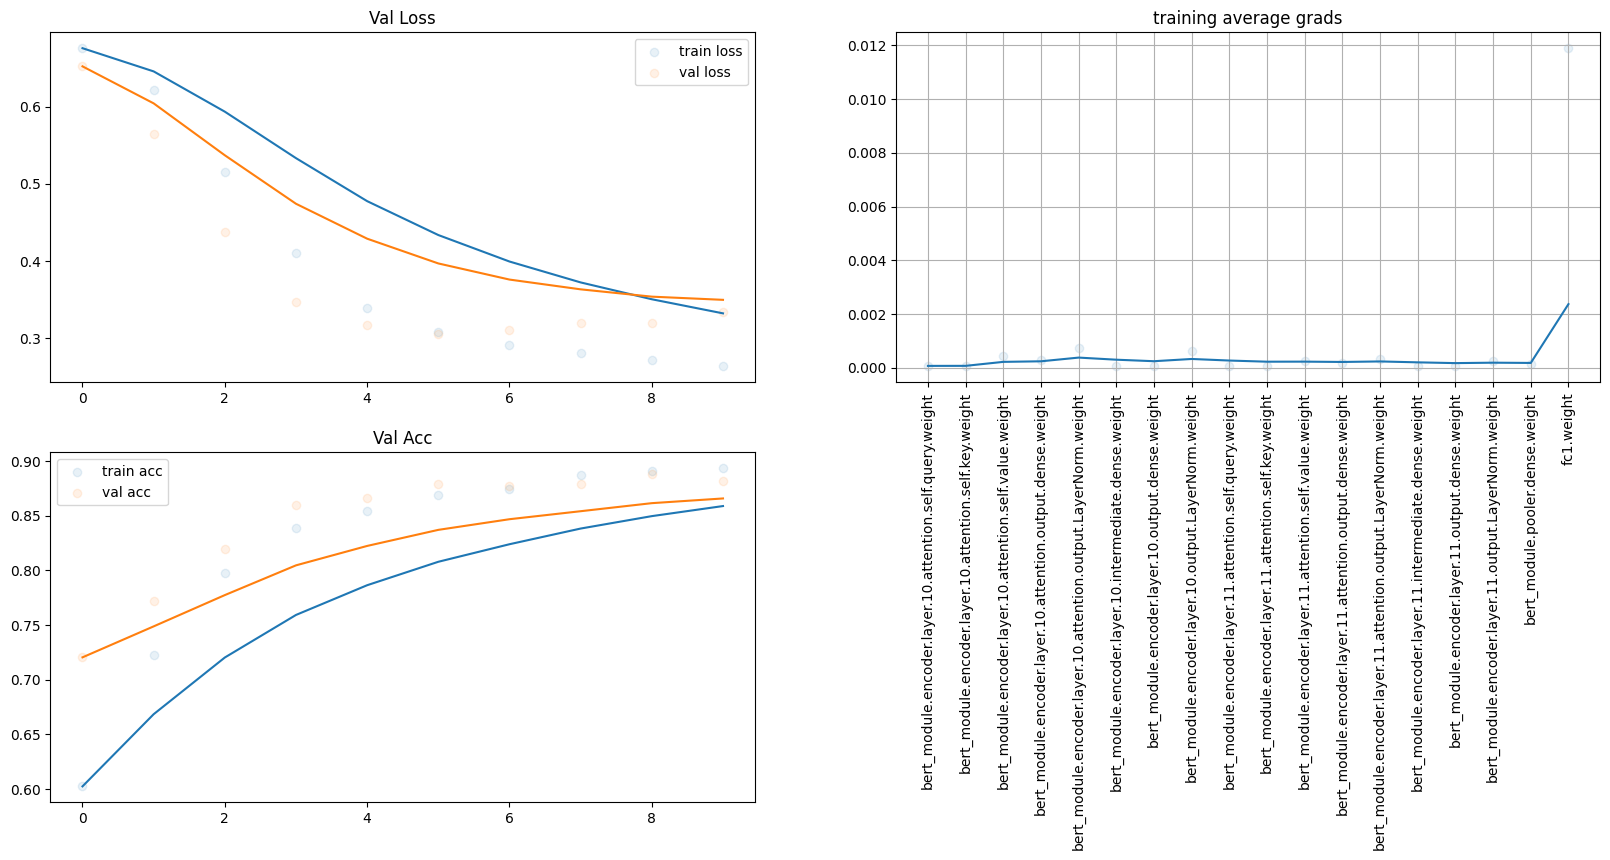

In [41]:
N_EPOCHS = 10
LEARNING_RATE=3e-6

bert_finetune_model = BERTClassifier(FROZEN_BERT, 2, False).to(DEVICE)

optimizer = optim.Adam(bert_finetune_model.parameters(), lr=LEARNING_RATE)
loss_func = nn.BCELoss()

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

train_epoch_loss_array, val_epoch_loss_array = [], []
train_acc_epoch_array, val_acc_epoch_array = [], []

for epoch in range(N_EPOCHS):
  train_loss, val_loss,  = 0, 0
  train_acc, val_acc = 0, 0
  #train
  bar=Progbar(len(finetune_loader))
  bert_finetune_model.train()
  bert_finetune_model.enable_bert_layers_training()
  for batch in finetune_loader:
    ids_vector, attention_vector, target = batch

    bert_finetune_model.zero_grad()
    pred_proba = bert_finetune_model(ids_vector, attention_vector).flatten()
    
    train_batch_loss = loss_func(pred_proba, target)
    train_loss += train_batch_loss.item()
    
    train_batch_loss.backward()
    clip_grad_norm_(parameters=bert_finetune_model.parameters(), max_norm=1.0)
    optimizer.step()

    #evaluate train acc
    pred_proba_np = pred_proba.cpu().detach().numpy() 
    predicted_targets = pred_proba_np > 0.5
    true_values = target.cpu().detach().numpy() 
    true_values = true_values == 1
    train_acc += (predicted_targets == true_values).astype(float).sum()
    bar.add(1)

  train_epoch_loss_array.append(train_loss / len(finetune_loader))
  train_acc_epoch_array.append(train_acc / len(finetune_dataset))

  #evaluate
  bar=Progbar(len(train_loader))
  bert_finetune_model.eval()
  bert_finetune_model.disable_bert_training()
  for batch in train_loader:
    with torch.no_grad():
      ids_vector, attention_vector, target = batch

      pred_proba = bert_finetune_model(ids_vector, attention_vector).flatten()
      
      val_batch_loss = loss_func(pred_proba, target)
      val_loss += val_batch_loss.item()

       #evaluate val acc
      pred_proba_np = pred_proba.cpu().detach().numpy() 
      predicted_targets = pred_proba_np > 0.5
      true_values = target.cpu().detach().numpy() 
      true_values = true_values == 1
      val_acc += (predicted_targets == true_values).astype(float).sum()
      bar.add(1)
      

  val_epoch_loss_array.append(val_loss / len(train_loader))
  val_acc_epoch_array.append(val_acc / len(train_dataset))


  clear_output(True)
  plt.figure(figsize=[20, 10])

  #plot train loss
  plt.subplot(2, 2, 1), plt.title('Train Loss'), plt.grid()
  plt.scatter(np.arange(len(train_epoch_loss_array)), train_epoch_loss_array, alpha=0.1, label='train loss')
  plt.plot(ewma(train_epoch_loss_array, span=10))
  plt.legend()

  #plot bert gradient change
  layers_list = []
  average_grads_list = []
  bert_finetune_model.enable_bert_layers_training()
  for layer_name, params in bert_finetune_model.named_parameters():
    if (params.requires_grad) and ("bias" not in layer_name):
      layers_list.append(layer_name)
      mean_gradient_value = params.grad.abs().mean().item()
      # total_sample_gradient_amount += params.grad.abs().sum().item()
      average_grads_list.append(mean_gradient_value)
  plt.subplot(2, 2, 2), plt.title('training average grads'), plt.grid()
  plt.scatter(layers_list, average_grads_list, alpha=0.1)
  plt.xticks(range(0,len(average_grads_list), 1), layers_list, rotation="vertical")
  plt.plot(ewma(average_grads_list, span=10))

  #plot train acc
  plt.subplot(2, 2, 3), plt.title('Train Acc'), plt.grid()
  plt.scatter(np.arange(len(train_acc_epoch_array)), train_acc_epoch_array, alpha=0.1, label='train acc')
  plt.plot(ewma(train_acc_epoch_array, span=10))
  plt.legend()

  #plot val loss
  plt.subplot(2, 2, 1), plt.title('Val Loss'), plt.grid()
  plt.scatter(np.arange(len(val_epoch_loss_array)), val_epoch_loss_array, alpha=0.1, label='val loss')
  plt.plot(ewma(val_epoch_loss_array, span=10))
  plt.legend()

  #plot val acc
  plt.subplot(2, 2, 3), plt.title('Val Acc'), plt.grid()
  plt.scatter(np.arange(len(val_acc_epoch_array)), val_acc_epoch_array, alpha=0.1, label='val acc')
  plt.plot(ewma(val_acc_epoch_array, span=10))
  plt.legend()

  plt.show()

In [43]:
#predict on test
bert_finetune_model.eval()
predicted_proba, bert_predicted, true_y = [], [], []
bar=Progbar(len(test_loader))
with torch.no_grad():
    for batch in test_loader:
        token_ids, masks, target = batch

        logits = bert_finetune_model(token_ids, masks)
        pred_proba = logits.cpu().detach().numpy()
        
        predicted_proba += list(pred_proba[:,0])
        bert_predicted += list(pred_proba[:, 0] > 0.5)
        true_y += list(target.cpu().detach().numpy())

        bar.add(1)

print('Average proba: ', np.array(predicted_proba).mean())
print(classification_report(true_y, bert_predicted))

125/125 [==============================] - 29s 230ms/step
Average proba:  0.51173794
              precision    recall  f1-score   support

         0.0       0.94      0.87      0.90       530
         1.0       0.86      0.94      0.90       470

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



### Сохраним нашу модель и опять загрузим - важный инструмент при работе с большими моделями

In [ ]:
 from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

if not os.path.exists('gdrive/MyDrive/Teaching/finetuned_bert'):
    os.makedirs('gdrive/MyDrive/Teaching/finetuned_bert')

torch.save(bert_finetune_model.state_dict(), 'gdrive/MyDrive/Teaching/finetuned_bert/finetuned_bert_model.pth')

In [ ]:
bert_loaded_model_path = 'gdrive/MyDrive/Teaching/finetuned_bert/finetuned_bert_model.pth'

bert_finetune_model = BERTClassifier(layers_freeze_num=10, debug_info=False).to(DEVICE)
bert_finetune_model.load_state_dict(torch.load(bert_loaded_model_path))
bert_finetune_model.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru